# **Applying DRL for FIR Filter Implementation - Stage 1 - Section 1** 

## Scope - *Generating Time Domain Signals, Analyzing Spectrums, and Evaluating BER*

### *Audio* Time Domain Signals and Priliminary Analysis 

In [3]:
import os, sys
import time
import numpy as np
import wave
from scipy.io import wavfile # scipy library to read wav. files
from scipy.fft import fft, ifft, rfft, irfft, fftshift, fftfreq
import matplotlib.pyplot as plt

%matplolib inline

UsageError: Line magic function `%matplolib` not found.


In [4]:
# define some useful functions 

def to_min_size_int_array(arr):
    """
    Convert the provided numpy array to a compatible numpy integer array with the minimum size possible

    :param arr: numpy array of floating point type
    """

    if np.min(arr) >= np.iinfo(np.int8).min and np.max(arr) <= np.iinfo(np.int8).max:
        print(f"converting from {arr.dtype} to {np.int8}; array ranges from min:  {np.min(arr)} (>={np.iinfo(np.int8).min})  to max: {np.max(arr)} (<={np.iinfo(np.int8).max})")
        return arr.astype(np.int8)
    if np.min(arr) >= np.iinfo(np.int16).min and np.max(arr) <= np.iinfo(np.int16).max:
        print(f"converting from {arr.dtype} to {np.int16}; array ranges from min: {np.min(arr)} (>={np.iinfo(np.int16).min}) to max: {np.max(arr)} (<={np.iinfo(np.int16).max})")
        return arr.astype(np.int16)
    if np.min(arr) >= np.iinfo(np.int32).min and np.max(arr) <= np.iinfo(np.int32).max:
        print(f"converting from {arr.dtype} to {np.int32}; array ranges from min: {np.min(arr)} (>={np.iinfo(np.int32).min}) to max: {np.max(arr)} (<={np.iinfo(np.int32).max})")
        return arr.astype(np.int32)
    
    # if np array is out of the ranges of np.int8, int16, and int32 integer data types, then raise an error
    print(f"array ranges from min: {np.min(arr)} to max: {np.max(arr)}")
    raise Exception(f"the array elements are too big to handle; {arr.dtype}")

def Spectrum(x, sampling_space: int=1, type: str='magnitude'):
    """
    Returns the spectrum of a given real-valued signal, 'x'. 

    :param x: the signal to find the spectrum 
    :param sampling_space: sampling period (the reciprocal of sampling frequency); defaults to 1
    :param type: specifies the output representation of the spectrum; defaults to 'magnitude'
        options:
        - 'magnitude': magnitude spectrum
        - 'phase':     phase spectrum (in radians)
        - 'complex':   complex-valued spectrum

    """
    spectrum = rfft(x) # note here, we use 'rfft' instead of 'fft'
    freq_bins = fftshift(fftfreq(len(x), sampling_space))
    freq_bins = freq_bins[-len(spectrum):] # get the frequency bins for half of the spectrum

    if type == 'magnitude':
        spectrum = np.abs(spectrum)
    elif type == 'phase':
        spectrum = np.angle(spectrum) # in radians
    elif type == 'complex':
        pass
    else:
        raise KeyError(f"{type} is not a valid option for the param 'type'.")

    return freq_bins, spectrum

sampling rate    : 44100 Hz
	audio shape: (136477,)
	converting from int16 to <class 'numpy.int16'>; array ranges from min: -13864 (>=-32768) to max: 14564 (<=32767)
	data type: int16


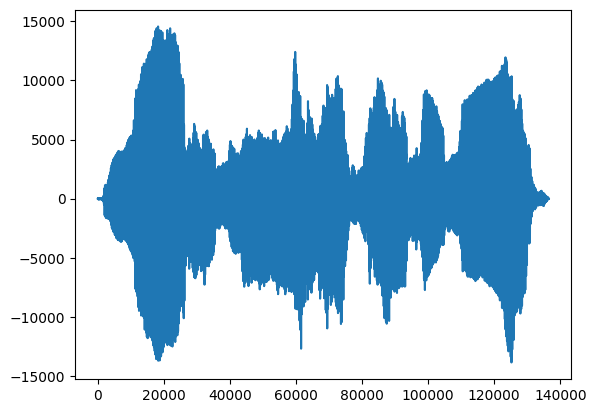

In [3]:
audio_dir_path = "audio_files/"
audio_src_file = "vignesh"

sampling_rate, audio_samples = wavfile.read(audio_dir_path+audio_src_file+'.wav')
sampling_space = 1/sampling_rate

print(f"sampling rate    : {sampling_rate} Hz")
if len(audio_samples.shape) == 1: # MONO
    print(f"\taudio shape: {audio_samples.shape}", end='\n\t')
    audio_samples = to_min_size_int_array(audio_samples)
    print(f"\tdata type: {audio_samples.dtype}")
elif len(audio_samples.shape) == 2 and audio_samples.shape[-1] == 2: # STEREO
    print("converting audio from STEREO to MONO...")
    print(f"\taudio shape before conversion: {audio_samples.shape}")
    print(f"\tdata type before conversion: {audio_samples.dtype}", end='\n\t')
    audio_samples = to_min_size_int_array(np.average(audio_samples, axis=-1))
    print(f"\taudio shape before conversion: {audio_samples.shape}")
    print(f"\tdata type after conversion: {audio_samples.dtype}")
    # saving the MONO audio file
    wavfile.write(f'{audio_dir_path+audio_src_file}-MONO.wav', rate=sampling_rate, data=audio_samples)
else:
    raise TypeError("unsupported wav file format")

plt.plot(audio_samples)

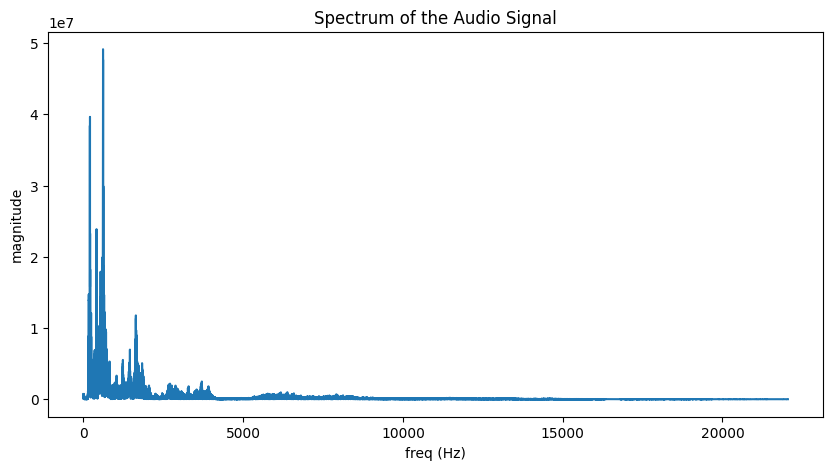

In [4]:
# find the spectrum of the audio signal 
freq_bins, spectrum = Spectrum(audio_samples, sampling_space)
plt.figure(figsize=(10, 5))
plt.plot(freq_bins, spectrum)
plt.title("Spectrum of the Audio Signal")
plt.xlabel("freq (Hz)")
plt.ylabel("magnitude")
plt.show()

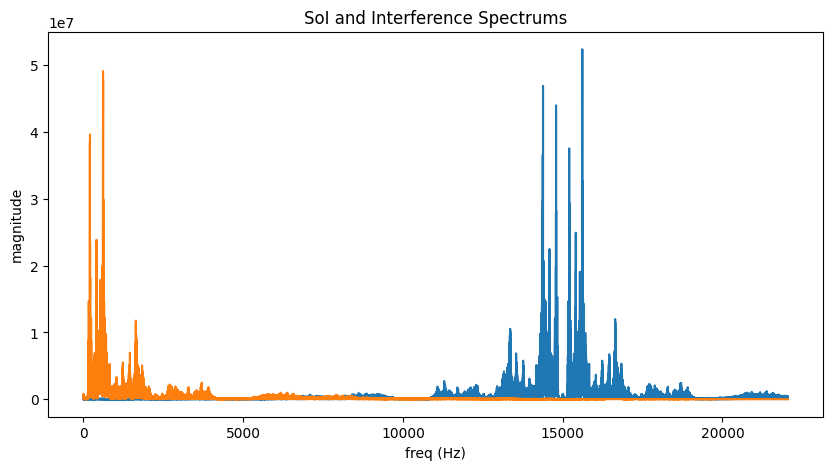

In [5]:
t = np.arange(len(audio_samples)) * sampling_space
interference_carrier_freq = 15_000 # Hz
interference = 2 * audio_samples * np.cos(2*np.pi*interference_carrier_freq*t)

_, interference_spectrum = Spectrum(interference)
plt.figure(figsize=(10, 5))
plt.plot(freq_bins, interference_spectrum)
plt.plot(freq_bins, spectrum)
plt.title("SoI and Interference Spectrums")
plt.xlabel("freq (Hz)")
plt.ylabel("magnitude")
plt.show()

### Spectrum Truncation

Usually, the spectrum of a signal exists all over the full frequency range of the spectrum: $[-\omega_s/2, \omega_s/2]$.
Most of the power of the signal is typically concentrated into the lower frequency ranges, but high frequncy componenets may still have low but non-zero power values. 

Therefore, once the interference is introduced around a higher center frequency, the two spectrums will overlap, creating an overlapping interference situation. 

Overlapping interferene is out of the scope of *STAGE 1* of DRL adaptive filter implementation. 
Therefore, the Signal of Interest (SoI) must have a clear cut-off frequency after which signal has no non-zero power components. 


68239 1.1012144154221043e+17
cut off frequency = 5352.671146053914 Hz; occupy 24.27533046103344% of the spectrum


Text(0.5, 1.0, 'Spectrum Truncated at the Cut-Off Frequency')

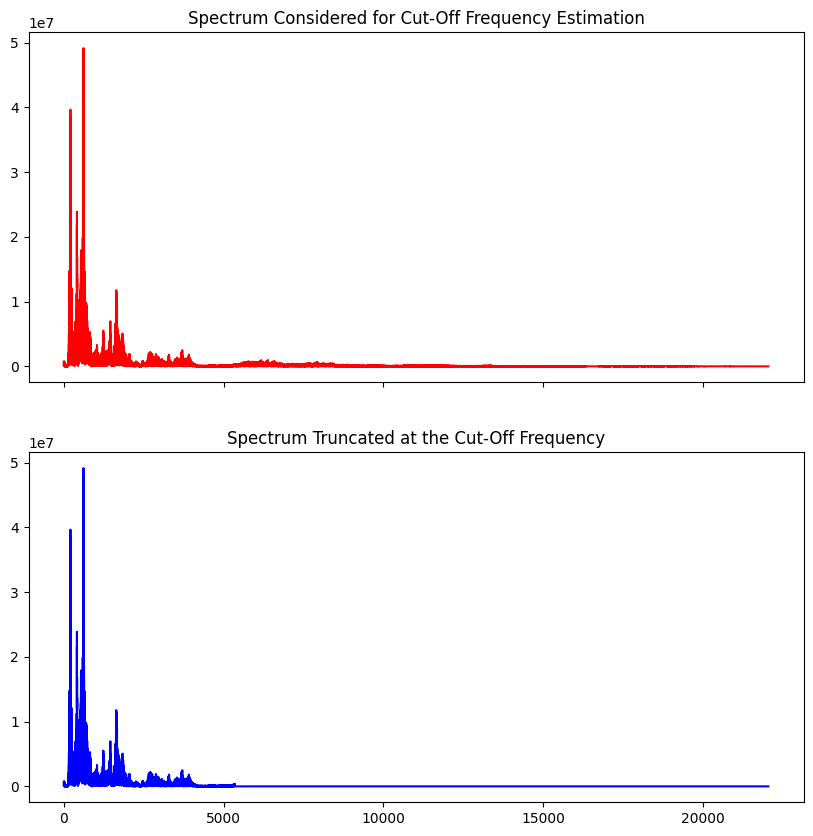

In [6]:
def power(arr):
    """
    return the power of the signal (arr) without normalization (i.e. 1/n is not performed.)
    this function can be used to compare the power of a signal both in time and frequency domains (see Parseval's Theorem.)
    """
    return np.sum(np.abs(arr) ** 2)

CUT_OFF_THRESH = 0.005     # the cut-off power threshold 
MAX_SIG_LENGTH = 1_000_000 # the maximum no. of signal samples considered for cut-off frequency calculation

original_signal_ = audio_samples
if len(original_signal_) > MAX_SIG_LENGTH: 
    # if the signal is too long, the signal must be truncated to reduce the time for cut-off frequency calculation
    original_signal_ = original_signal_[:MAX_SIG_LENGTH]
freq_bins_, spectrum_ = Spectrum(original_signal_, sampling_space=sampling_space)

total_power = power(spectrum_) # same as 'np.sum(spectrum_**2)'
cut_off_thresh = freq_bins_[-1]
print(len(spectrum_), total_power)
high_freq_power = 0

for limit in range(len(spectrum_)-1, 0, -1):
    # traversing the spectrum_ from right to left
    high_freq_power += np.abs(spectrum_[limit])**2
    # print(limit, high_freq_power)
    if high_freq_power > CUT_OFF_THRESH * total_power:
        # then the cut-off threshold has been surpassed
        cut_off_thresh = freq_bins_[limit + 1]
        break
cut_off_freq_ratio = cut_off_thresh/freq_bins_[-1]

rect_filter_ = np.zeros(len(spectrum_))
rect_filter_[:limit+1] = 1

print(f"cut off frequency = {cut_off_thresh} Hz; occupy {cut_off_freq_ratio*100}% of the spectrum")
fig, axs = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10, 10))
axs[0].plot(freq_bins_, spectrum_, 'r') # magnitude spectrum
axs[0].set_title("Spectrum Considered for Cut-Off Frequency Estimation")
axs[1].plot(freq_bins_, spectrum_ * rect_filter_, 'b') # magnitude spectrum
axs[1].set_title("Spectrum Truncated at the Cut-Off Frequency")

In [ ]:
# let's evaluate how distant x and irfft(rfft(x)) are. 
temp = fft(audio_samples)
est_audio_samples = ifft(temp).astype(np.int32)
RMS_distance = np.sqrt(np.sum((audio_samples - est_audio_samples)**2)/len(audio_samples))
print(f"RMS distance = {RMS_distance}")

converting from float64 to <class 'numpy.int16'>; array ranges from min: -16542.72599462708 (>=-32768) to max: 17132.350611134087 (<=32767)
cut off frequency = 2602.5615 Hz; occupy 11.80302360604721% of the spectrum


Text(0.5, 1.0, 'Target Audio Spectrum')

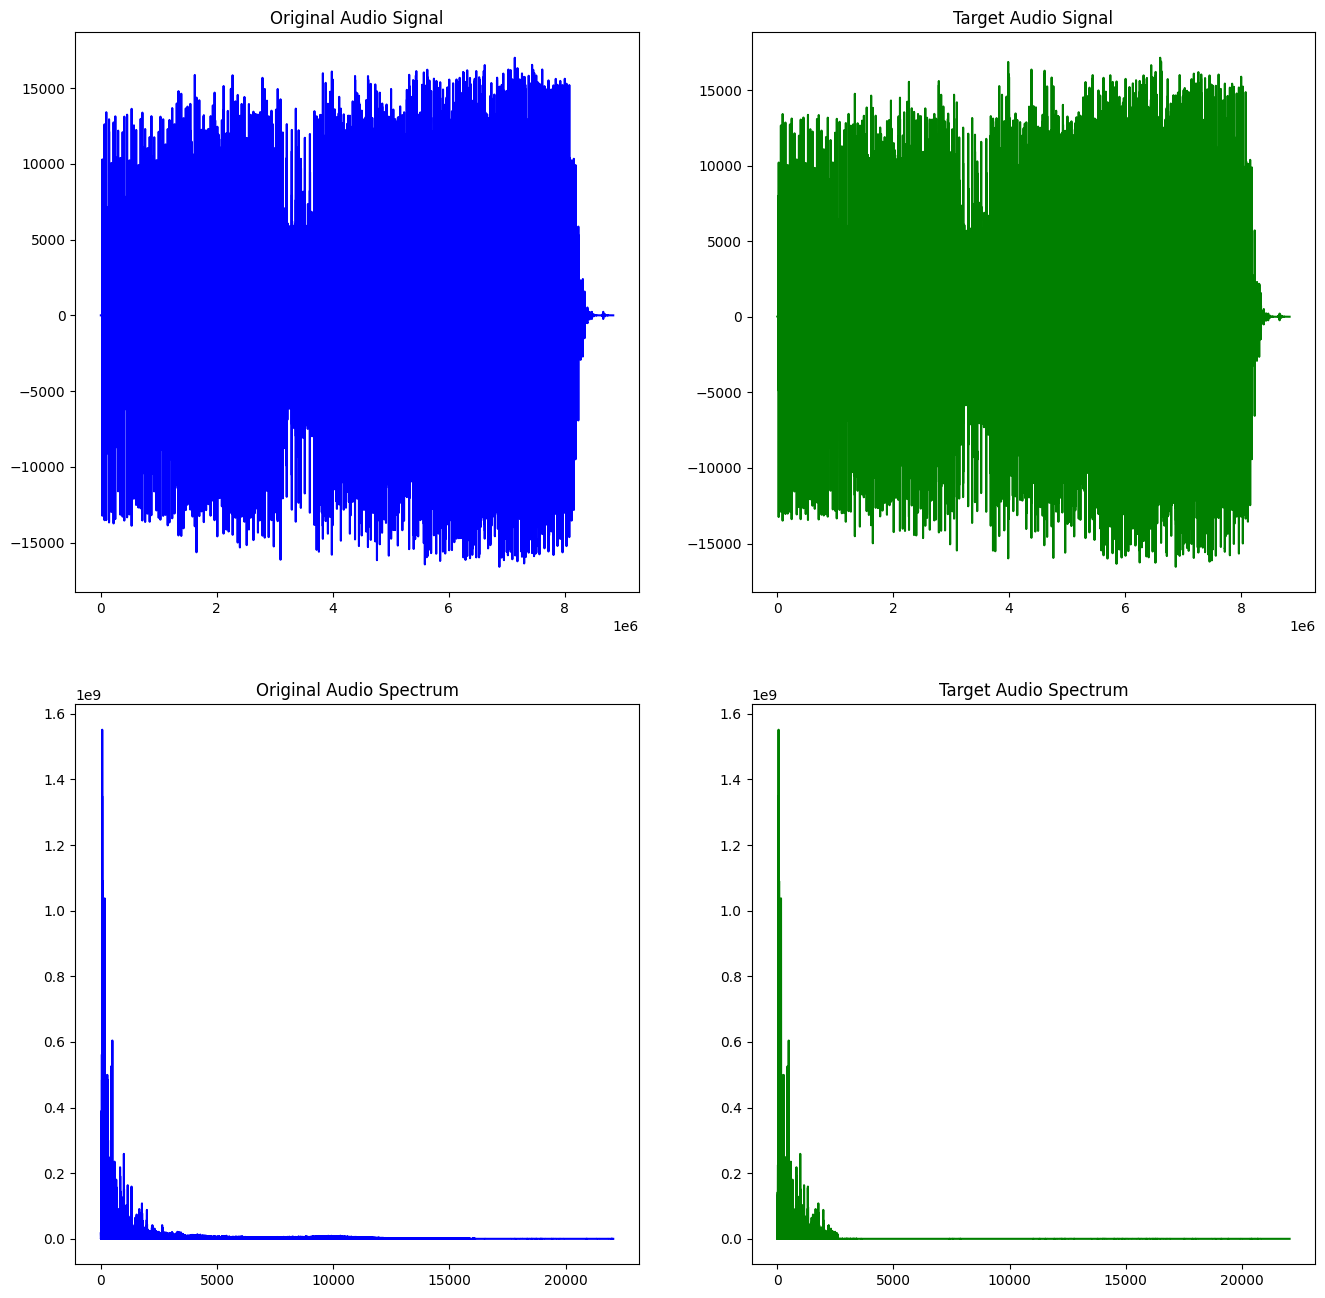

In [7]:
# apply the cut-off frequency to complete spectrum 
original_signal = audio_samples
freq_bins, original_spectrum = Spectrum(original_signal, sampling_space=sampling_space, type='complex')

rect_filter = (freq_bins < cut_off_thresh).astype(np.uint8)
target_spectrum = original_spectrum * rect_filter
target_signal = to_min_size_int_array(irfft(target_spectrum)) # converting to an integer format 

# save the test signal
audio_dest_file = audio_src_file + "-target" + "-MONO"
wavfile.write(audio_dir_path+audio_dest_file+'.wav', rate=sampling_rate, data=target_signal)

print(f"cut off frequency = {cut_off_thresh} Hz; occupy {cut_off_freq_ratio*100}% of the spectrum")
# plotting time domain signals 
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 16))
axs[0][0].plot(original_signal, 'b')
axs[0][0].set_title("Original Audio Signal")
axs[0][1].plot(target_signal, 'g')
axs[0][1].set_title("Target Audio Signal")
# plotting the spectrums
axs[1][0].plot(*Spectrum(original_signal, sampling_space=sampling_space), 'b')
axs[1][0].set_title("Original Audio Spectrum")
axs[1][1].plot(*Spectrum(target_signal,   sampling_space=sampling_space), 'g')
axs[1][1].set_title("Target Audio Spectrum")

### Generating Non-Overlapping Interference Signal and Corresponding Jammed Signal

shift frequency must be in the range of [5205.123, 19447.433509903247]
converting from float64 to <class 'numpy.int32'>; array ranges from min: -48329.505354661516 (>=-2147483648) to max: 48857.44065656121 (<=2147483647)


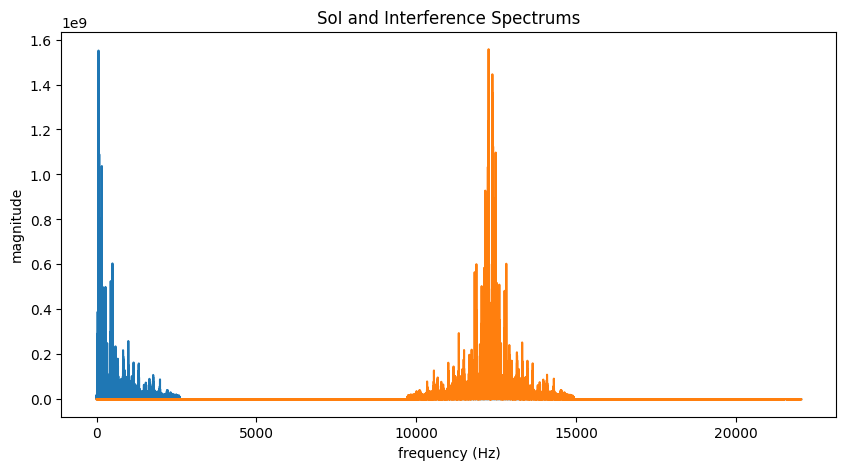

In [9]:
# creating a non-overlapping interference signal 
# let's use our truncated target signal to create the interference as well. 
# First, find the range of the interference center frequency to have the shifted target signal spectrum as a non-overlapping interference

interference_center_freq_lower_limit = cut_off_thresh + cut_off_thresh
interference_center_freq_upper_limit = freq_bins[-1]  - cut_off_thresh # note that all the spectrums are symmetric
print(f"shift frequency must be in the range of [{interference_center_freq_lower_limit}, {interference_center_freq_upper_limit}]")

# plt.figure(figsize=(10, 5))
# plt.plot(*Spectrum(target_signal))
# plt.plot(np.arange(np.ceil(interference_center_freq_lower_limit, dtype=np.int16),  np.ceil(interference_center_freq_upper_limit), dtype=np.int16), 
#          np.ones  (np.ceil(interference_center_freq_upper_limit, dtype=np.int16) - np.ceil(interference_center_freq_lower_limit), dtype=np.int16), 'r')

# choose a carrier frequency for shifting 
shift_freq = (interference_center_freq_lower_limit + interference_center_freq_upper_limit)/2

# generate the interference signal
t = np.arange(len(target_signal)) * sampling_space
interference = (2 * target_signal * np.cos(2*np.pi*shift_freq*t)) # .astype(default_dtype) # converting to np.int32

# save the interference signal
audio_dest_file = audio_src_file + "-interference" + "-MONO"
# wavfile.write(audio_dir_path+audio_dest_file+'.wav', rate=sampling_rate, data=interference)

# generate the jammed signal
INTERFRERENCE_SCALAR = 1   # the scaling factor of the interference signal
jammed_signal = to_min_size_int_array(target_signal + INTERFRERENCE_SCALAR * interference) #.astype(np.int16)

# save the jammed signal
audio_dest_file = audio_src_file + "-jammed" + "-MONO"
wavfile.write(audio_dir_path+audio_dest_file+'.wav', rate=sampling_rate, data=jammed_signal)


plt.figure(figsize=(10, 5))
plt.plot(*Spectrum(target_signal, sampling_space))
plt.plot(*Spectrum(interference, sampling_space))
plt.title("SoI and Interference Spectrums")
plt.xlabel("frequency (Hz)")
plt.ylabel("magnitude")
plt.show()


- Now, here, we have a problem; *the constructed jammed signal (for vignesh) surpasses the range of the np.int16 and hence requires to be recorded as an np.int32 array, which creates excessively large files to store and handle by the successive operations*. 
- let's analyze the range of the constructed jammed signal and check whether the large samples can be clipped to fit into the np.int16 range without loosing much information. 

In [ ]:
print(f"the jammed signal ranges from min: {np.min(jammed_signal)} to max: {np.max(jammed_signal)}")
print(f"range for np.int16, min: {np.iinfo(np.int16).min}, max: {np.iinfo(np.int16).max}")

# how many audio samples surpass this limit of np.int16
outlier_count = np.count_nonzero((np.abs(jammed_signal) > np.iinfo(np.int16).max).astype(np.uint8))
print(f"outlier count: {outlier_count}, outlier ratio: {outlier_count/len(jammed_signal)}")

# WE WILL DO THE CAPPING LATER

### Evaluating the Effect of Non-Overlapping Interference on Bit Error Rate (BER)

In [ ]:
# helper functions

def unpackbits(sample_array):
    "unpack a numpy array of samples into a stram of bits (str) according to the datatype/precision of the array elements"
    if   sample_array.dtype == np.int32: precision = 32
    elif sample_array.dtype == np.int16: precision = 16
    elif sample_array.dtype == np.uint8: precision =  8
    else:
        raise TypeError("the numpy datatype of the provided array is not compatible.")

    # format_ = lambda sample: np.array(list((format(sample, f'0>{precision}b')))).astype(np.uint8)
    format_ = lambda sample: np.array(list(f"{sample & ((1 << precision) - 1):0{precision}b}")).astype(np.int8)
    # some references:
    # - python format function: 'http://www.trytoprogram.com/python-programming/python-built-in-functions/format/'
    # - using format with numpy arrays - 'https://stackoverflow.com/a/52824395/21146493'
    # - implementing two's complement in python - 'https://stackoverflow.com/a/63274998/21146493'

    return np.array(list(map(format_, sample_array)))

def biterrorcount(target_bit_stream, received_bit_stream):
    "calculates the bit error count of the received bit stream compared to the target bit stream"
    return np.count_nonzero(np.bitwise_xor(target_bit_stream, received_bit_stream))

In [ ]:
# finding the bit streams and evaluating the bit error counts 
# let's save these bit streams in txt files; remember they take longer times to compute

raise SystemExit("the following code is not ready to run...")

log_path = "logs/"
target_bit_stream_file   = log_path + audio_src_file + "-target" + "-MONO" + "-bits" + '.npy'
received_bit_stream_file = log_path + audio_src_file + "-jammed" + "-MONO" + "-bits" + '.npy'

os.makedirs(log_path, exist_ok=True)
if os.path.exists(target_bit_stream_file):
    # if the file already exists, the file must be removed. 
    # otherwise, once the 'np.save' function is called, the new array will be appended to the end of the file as a new array. 
    print(f"removing file: {target_bit_stream_file}")
    os.remove(target_bit_stream_file)
if os.path.exists(received_bit_stream_file):
    print(f"removing file: {received_bit_stream_file}")
    os.remove(received_bit_stream_file)

target_bit_stream = unpackbits(target_signal).flatten()
np.save(target_bit_stream_file, target_bit_stream)

received_bit_stream = unpackbits(jammed_signal).flatten()
np.save(received_bit_stream_file, received_bit_stream)

bit_error_count = biterrorcount(target_bit_stream, received_bit_stream)
print(f"no. of audio sample : {len(target_signal)}")
print(f"no. of received bits: {len(received_bit_stream)}")
print(f"bit error count     : {bit_error_count}")
print(f"bit error rate (BER): {bit_error_count/len(received_bit_stream)}")

In [ ]:
# now, let's investigate how different interference levels affect the BER rate of the signal
# WARNING - following code must be only run for relatively small audio signals... 

raise SystemExit("the following code is not ready to run...")

MAX_BIT_STREAM_LENGTH = 5_000_000 # just to allow 'vignesh.wav'
if len(received_bit_stream) > MAX_BIT_STREAM_LENGTH:
    raise Exception(f"the specified bit stream surpasses the maximum bit stream length, {MAX_BIT_STREAM_LENGTH}") 

interference_scalars = [0.001, 0.005, 0.01, 0.02, 0.05, 0.08, 0.1, 0.2, 0.4, 0.5, 0.55, 0.6, 0.7, 0.8, 0.9, 1]
BERs = []
for interference_scalar in interference_scalars:
    jammed_signal_ = (target_signal + interference_scalar * interference).astype(target_signal.dtype)
    received_bit_stream_ = unpackbits(jammed_signal_).flatten()
    bit_error_count = biterrorcount(target_bit_stream, received_bit_stream_)
    bit_error_rate  = bit_error_count/len(target_bit_stream)
    BERs.append(bit_error_rate)

plt.figure(figsize=(10, 5))
plt.plot(interference_scalars, BERs)
plt.plot(interference_scalars, BERs, 'o')
plt.title("Interference Scaling vs BER")
plt.xscale('log')
plt.xlabel("interference scaling factor")
plt.ylabel("BER values")

### Building a function to create jammed and target signals online while training

In [5]:
def create_target_and_jammed_signals(audio_name, truncation_freq, interference_center_freq, audio_file_dir='audio_files/', save_files=False):
    """
    Creates the target and jammed signals with the specified truncation frequnecy and the interference center frequency.
    :param audio_name: name of the audio .wav file (without the .wav extension)
    :param truncation_freq: the frequency to truncate the audio spectrum to generate the target signal
    :param interference_center_freq: the frequency to shift the target spectrum to generate the non-overlapping interference \n(`truncation_freq` and `interference_center_freq`) \
        must be chosen appropriately to create non-overlapping interferences; otherwise, errors will be raised.
    :param audio_file_dir: the path to the directory containing the audio file
    :param save_files: boolean value indicating whether to write the resulting (MONO), truncated, and jammed signals
    """

    SAMPLING_FREQ = 44_100 # each audio file must have a constant sampling freq to equally apply the truncation and interference center frequencies
    INTERFRERENCE_SCALAR = 1   # the scaling factor of the interference signal
    print(f"audio name: '{audio_name}'")

    # ------------------------------------------ read the input audio ------------------------------------------
    audio_src_file = os.path.join(audio_file_dir, audio_name+'.wav')
    if not os.path.exists(audio_src_file):
        raise Exception(f"the specified audio file doesn't exist: given {audio_src_file}")
    sampling_rate, audio = wavfile.read(audio_src_file)
    sampling_space = 1/sampling_rate
    print(f"sampling rate    : {sampling_rate} Hz")

    if (sampling_rate != SAMPLING_FREQ):
        raise Exception(f"Error - the sampling rate must be equal to {SAMPLING_FREQ}Hz: given {sampling_rate}")
    if (interference_center_freq < 2 * truncation_freq):
        raise Exception(f"Error - non-overlapping interferene is impossible with the provided truncation and interference center frequencies: given {truncation_freq} and {interference_center_freq}")
    if (interference_center_freq + truncation_freq > sampling_rate):
        raise Exception(f"Error - interference signal surpasses the sampling freqency of the original audio.")

    # ----------------------------------------- coverting to MONO audio ----------------------------------------
    print(f"audio shape: {audio.shape}")
    print(f"data type: {audio.dtype}")
    
    if len(audio.shape) == 1: # MONO
        print("MONO audio file...")
        
    elif len(audio.shape) == 2 and audio.shape[-1] == 2: # STEREO
        print("converting audio from STEREO to MONO...")
        audio = np.average(audio, axis=-1).astype(audio.dtype)
        print(f"\taudio shape: {audio.shape}")
        print(f"\tdata type  : {audio.dtype}")

        # if save_files:
        # saving the MONO audio file
        mono_dst_file = os.path.join(audio_file_dir, audio_name+'-MONO.wav')
        print(f"\tsaving MONO audio: '{mono_dst_file}'...")
        wavfile.write(mono_dst_file, rate=sampling_rate, data=audio)
    else:
        raise TypeError("unsupported wav file format")

    # --------------------------------------- truncate the signal spectrum --------------------------------------
    # apply the cut-off frequency to audio spectrum 
    freq_bins, spectrum = Spectrum(audio, sampling_space=sampling_space, type='complex')

    print(f"truncating the spectrum at {truncation_freq}Hz...")
    rect_filter = (freq_bins < truncation_freq).astype(np.uint8)
    target_spectrum = spectrum * rect_filter
    target_signal = to_min_size_int_array(irfft(target_spectrum)) # converting to an integer format #######

    if save_files:
        # save the test signal
        target_dst_file = os.path.join(audio_file_dir, audio_name + "-target-MONO.wav")
        print(f"saving target signal: '{target_dst_file}'...")
        wavfile.write(target_dst_file, rate=sampling_rate, data=target_signal)
    
    # ---------------------------------------- create the jammed signal -----------------------------------------
    # creating a non-overlapping interference signal 
    t = np.arange(len(target_signal)) * sampling_space
    interference = (2 * target_signal * np.cos(2*np.pi*interference_center_freq*t)) # .astype(default_dtype) # converting to np.int32

    # generate the jammed signal
    jammed_signal = to_min_size_int_array(target_signal + INTERFRERENCE_SCALAR * interference) #.astype(np.int16)

    if save_files:
        # save the jammed signal
        jammed_dst_file = os.path.join(audio_file_dir, audio_name + "-jammed-MONO.wav")
        print(f"saving jammed signal: '{jammed_dst_file}'...")
        wavfile.write(jammed_dst_file, rate=sampling_rate, data=jammed_signal)

    return target_signal, jammed_signal
    

In [6]:
# convert the audio signals

CUT_OFF_FREQ = 5_000 #Hz
INTERFERENCE_CENTER_FREQ = 12_000 #Hz

save_files = False
audio_names = [ # add the names without 'MONO'. If 'STEREO', MONO file will be created... 
    'arms_around_you',
    'rain_on_me',
    'august',
    'breathin'
]
for name in audio_names:
    create_target_and_jammed_signals(name, CUT_OFF_FREQ, INTERFERENCE_CENTER_FREQ)

audio name: 'arms_around_you'
sampling rate    : 44100 Hz
audio shape: (8631296, 2)
data type: int16
converting audio from STEREO to MONO...
	audio shape: (8631296,)
	data type  : int16
	saving MONO audio: 'audio_files/arms_around_you-MONO.wav'...
truncating the spectrum at 5000Hz...
converting from float64 to <class 'numpy.int16'>; array ranges from min: -31316.608957868415 (>=-32768) to max: 31370.627685823245 (<=32767)
converting from float64 to <class 'numpy.int32'>; array ranges from min: -49152.0 (>=-2147483648) to max: 49142.518038333495 (<=2147483647)
audio name: 'rain_on_me'
sampling rate    : 44100 Hz
audio shape: (8305664, 2)
data type: int16
converting audio from STEREO to MONO...
	audio shape: (8305664,)
	data type  : int16
	saving MONO audio: 'audio_files/rain_on_me-MONO.wav'...
truncating the spectrum at 5000Hz...
converting from float64 to <class 'numpy.int16'>; array ranges from min: -18879.494656565814 (>=-32768) to max: 17182.003427808108 (<=32767)
converting from fl